# Searching for DMRs with BioConductor's bumphunter

This notebook searches for Differentially Methylated Regions (DMRs) along the genome using 450k array data and the [bumphunter function from Bioconductor](https://bioconductor.org/packages/release/bioc/html/bumphunter.html). The packages statistical methods are outlined in the [authors' 2012 publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3304533/). The purposes of this notebook are to 1) adjust the parameters of the bumphunter function and examine how the identified DMRs change in response and 2) create benchmark results against which to compare the performance of the forthcoming python version of the package.

### Load minfi package from which bumphunter function will be called

In [1]:
library(minfi)
wd_path <- getwd()
##filepath to folder of sample liver 450k array data
basepath <- paste(wd_path,"GSE69852_copy",sep="/")
basepath

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Loading required package: GenomicRanges
Loading required packag

[1] "C:/Users/Alanna/Documents/Life Epigenetics/BumphunterBenchmarksR/GSE69852_copy"

## Read in raw array data and associated sample information

Read in the data from the samplesheet corresponding to these samples. Example data is from [Huse et al. 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4654795/) available from GEO under accession number [GSE69852](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE69852).

Phenotype data for age and sex were added manually to the sample sheet for this exercise. The adult ages are NOT exact for each individual, but rather represent the average age of the adults who were described as "55 to 62 year olds."

In [2]:
targets <- read.metharray.sheet(basepath)
targets

[read.metharray.sheet] Found the following CSV files:


[1] "C:/Users/Alanna/Documents/Life Epigenetics/BumphunterBenchmarksR/GSE69852_copy/samplesheet.csv"


GSM_ID,Sample_Name,Sex,Age,Array,Slide,Basename
GSM1711360,AdultLiver1,Male,58,R02C01,9247377093,C:/Users/Alanna/Documents/Life Epigenetics/BumphunterBenchmarksR/GSE69852_copy/GSM1711360_9247377093_R02C01
GSM1711361,AdultLiver2,Male,58,R03C01,9247377093,C:/Users/Alanna/Documents/Life Epigenetics/BumphunterBenchmarksR/GSE69852_copy/GSM1711361_9247377093_R03C01
GSM1711362,AdultLiver3,Male,58,R06C02,9247377093,C:/Users/Alanna/Documents/Life Epigenetics/BumphunterBenchmarksR/GSE69852_copy/GSM1711362_9247377093_R06C02
GSM1711363,FetalLiver1,Male,0,R04C02,9247377085,C:/Users/Alanna/Documents/Life Epigenetics/BumphunterBenchmarksR/GSE69852_copy/GSM1711363_9247377085_R04C02
GSM1711364,FetalLiver2,Male,0,R05C01,9247377093,C:/Users/Alanna/Documents/Life Epigenetics/BumphunterBenchmarksR/GSE69852_copy/GSM1711364_9247377093_R05C01
GSM1711365,FetalLiver3,Male,0,R02C02,9247377093,C:/Users/Alanna/Documents/Life Epigenetics/BumphunterBenchmarksR/GSE69852_copy/GSM1711365_9247377093_R02C02


In [3]:
##Read the raw IDAT file intensities into a red-green channel dataset
RGset <- read.metharray.exp(targets=targets)

In [4]:
##Explore the phenotypes associated with these samples
phenoData <- pData(RGset)
phenoData[,1:6]

DataFrame with 6 rows and 6 columns
                                  GSM_ID Sample_Name         Sex       Age
                             <character> <character> <character> <integer>
GSM1711360_9247377093_R02C01  GSM1711360 AdultLiver1        Male        58
GSM1711361_9247377093_R03C01  GSM1711361 AdultLiver2        Male        58
GSM1711362_9247377093_R06C02  GSM1711362 AdultLiver3        Male        58
GSM1711363_9247377085_R04C02  GSM1711363 FetalLiver1        Male         0
GSM1711364_9247377093_R05C01  GSM1711364 FetalLiver2        Male         0
GSM1711365_9247377093_R02C02  GSM1711365 FetalLiver3        Male         0
                                   Array       Slide
                             <character> <character>
GSM1711360_9247377093_R02C01      R02C01  9247377093
GSM1711361_9247377093_R03C01      R03C01  9247377093
GSM1711362_9247377093_R06C02      R06C02  9247377093
GSM1711363_9247377085_R04C02      R04C02  9247377085
GSM1711364_9247377093_R05C01      R05C01  9247

In [4]:
 ##Load manifest from Bioconductor annotation package for Illumina 450k array: IlluminaHumanMethylation450kmanifest
manifest <- getManifest(RGset)
manifest

Loading required package: IlluminaHumanMethylation450kmanifest


IlluminaMethylationManifest object
Annotation
  array: IlluminaHumanMethylation450k
Number of type I probes: 135476 
Number of type II probes: 350036 
Number of control probes: 850 
Number of SNP type I probes: 25 
Number of SNP type II probes: 40 

In [5]:
##Take a look at the data associated with each probe
head(getProbeInfo(manifest))

DataFrame with 6 rows and 8 columns
         Name    AddressA    AddressB       Color       NextBase
  <character> <character> <character> <character> <DNAStringSet>
1  cg00050873    32735311    31717405         Red              A
2  cg00212031    29674443    38703326         Red              T
3  cg00213748    30703409    36767301         Red              A
4  cg00214611    69792329    46723459         Red              A
5  cg00455876    27653438    69732350         Red              A
6  cg01707559    45652402    64689504         Red              A
                ProbeSeqA               ProbeSeqB      nCpG
           <DNAStringSet>          <DNAStringSet> <integer>
1 ACAAAAAAAC...ATAAACCCCA ACGAAAAAAC...ATAAACCCCG         2
2 CCCAATTAAC...AAAACATACA CCCAATTAAC...AAAACGTACG         4
3 TTTTAACACC...AAAAAAAACA TTTTAACGCC...AAAAAAAACG         3
4 CTAACTTCCA...AACACAAACA CTAACTTCCG...AACGCGAACG         5
5 AACTCTAAAC...AAAAAACTCA AACTCTAAAC...AAAAAACTCG         2
6 ACAAATTAAA...ACAAAAAAC

## Normalize and process raw data

<b>Quantile processing</b> is recommended when you don't expect global differences, like those found between tissue types or in cancer vs. normal comparisons. Given that these arrays all use healthy liver tissue samples, quantile processing is a reasonable option from the <span style="font-family:Courier">minfi</span> normalization methods available.

Our methylation pipeline has primarily been using <b>noob</b> to normalize raw data, however, so that <span style="font-family:Courier">minfi</span> method will also be employed here to see if the normalization method impacts the size or location of DMRs found by <span style="font-family:Courier">bumphunter</span>.

In [6]:
##Process the red-green intensities into Beta and M-values mapped to their genomic locations
    ##fixes outliers and normalizes data through stratified quantile normalization
    ##applies process to methylated and unmethylated intensities separately
    ##normalizes Type II probes first and then uses that as a reference distribution for the Type I probes
GRSet_quantile <- preprocessQuantile(RGset,sex="M") 
GRSet_quantile

[preprocessQuantile] Mapping to genome.
Loading required package: IlluminaHumanMethylation450kanno.ilmn12.hg19
[preprocessQuantile] Fixing outliers.
[preprocessQuantile] Quantile normalizing.


class: GenomicRatioSet 
dim: 485512 6 
metadata(0):
assays(2): M CN
rownames(485512): cg13869341 cg14008030 ... cg08265308 cg14273923
rowData names(0):
colnames(6): GSM1711360_9247377093_R02C01 GSM1711361_9247377093_R03C01
  ... GSM1711364_9247377093_R05C01 GSM1711365_9247377093_R02C02
colData names(8): GSM_ID Sample_Name ... Basename filenames
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19
Preprocessing
  Method: Raw (no normalization or bg correction)
  minfi version: 1.28.0
  Manifest version: 0.4.0

In [7]:
##Noob is a background correction method with dye-bias normalization for the Illumina Infinium HumanMethylation450 platform
MSet_noob <- preprocessNoob(RGset)
MSet_noob

class: MethylSet 
dim: 485512 6 
metadata(0):
assays(2): Meth Unmeth
rownames(485512): cg00050873 cg00212031 ... ch.22.47579720R
  ch.22.48274842R
rowData names(0):
colnames(6): GSM1711360_9247377093_R02C01 GSM1711361_9247377093_R03C01
  ... GSM1711364_9247377093_R05C01 GSM1711365_9247377093_R02C02
colData names(8): GSM_ID Sample_Name ... Basename filenames
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19
Preprocessing
  Method: NA
  minfi version: NA
  Manifest version: NA

In [8]:
##Noob preprocessing creates a MethylSet class object, which is not yet mapped to the genome
MSet_noob_mapped <- mapToGenome(MSet_noob)

##After being mapped, it still needs to be converted to a GenomicRatioSet before it can be input to bumphunter()
GRSet_noob <- ratioConvert(MSet_noob_mapped)
GRSet_noob

class: GenomicRatioSet 
dim: 485512 6 
metadata(0):
assays(2): Beta CN
rownames(485512): cg13869341 cg14008030 ... cg08265308 cg14273923
rowData names(0):
colnames(6): GSM1711360_9247377093_R02C01 GSM1711361_9247377093_R03C01
  ... GSM1711364_9247377093_R05C01 GSM1711365_9247377093_R02C02
colData names(8): GSM_ID Sample_Name ... Basename filenames
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19
Preprocessing
  Method: NA
  minfi version: NA
  Manifest version: NA

## Prepare phenotype design matrix for bumphunter input

All of the iterations of <span style="font-family:Courier">bumphunter</span> run below are using the same sample pool with the same phenotype designations, so this design matrix can be used in the function every time. In this dataset, it's age (adult vs. fetal). Because the ages aren't exact for either group, this is more like a binary design matrix than a continuous variable.

In [9]:
pheno.design <- pData(GRSet_quantile)$Age
designMatrix <- model.matrix(~ pheno.design)
designMatrix

,(Intercept),pheno.design
1,1,58
2,1,58
3,1,58
4,1,0
5,1,0
6,1,0


## All tested parameter combinations

The following is a table that outlines the 32 different iterations of <span style="font-family:Courier">bumphunter</span> that will be run to see how the DMRs detected may change in size, location, or quantity within the same sample set as parameters are adjusted. First the data will be normalized with two different methods, next bumphunter will use either the Beta or M measures for methylation, then the <span style="font-family:Courier">maxGap</span> value that determines the maximum genomic distance allowed between CpGs in the same cluster, and finally the function will be allowed to pick the cutoff value for bumps at either the 95th percentile or 99th percentile of the regression data.

![Table of 32 different parameter combinations to be tested](FunctionTestDesign.png)

A recent [comparative study by Mallik et al.](https://academic.oup.com/bib/advance-article/doi/10.1093/bib/bby085/5096828#121447126) found that <span style="font-family:Courier">bumphunter</span> performed best in correctly identifying DMRs in their simulated dataset when <span style="font-family:Courier">maxGap=250</span> and <span style="font-family:Courier">pickCutoff</span> was set to the 95th percentile.

In [10]:
##Set up vectors for each parameter setting
normalizations <- c("Quantile","Noob")
measures <- c("Beta","M")
gaps <- c(200,250,500,750)
cutoffs <- c(0.95,0.99)

In [11]:
##Include columns for the number of bumps on each chromosome
chr <- as.factor(seqnames(GRSet_quantile))
chromosomes <- levels(chr)

##Create a table to hold basic data about each bumphunter run including the cutoff value used and the number of DMRs found
results_matrix <- matrix(0,32,30)
dmr_results_table <- data.frame(results_matrix)
colnames(dmr_results_table) <- c("Normalization","Measure","MaxGap","CutoffQ","NumberBumps","CutoffValue",chromosomes)

##Fill in table with parameter design displayed above
row <- 1
for (n in 1:length(normalizations)){ 
    for (m in 1:length(measures)){
        for (g in 1:length(gaps)){
            for (q in 1:length(cutoffs)){
                dmr_results_table$Normalization[row] <- normalizations[n]
                dmr_results_table$Measure[row] <- measures[m]
                dmr_results_table$MaxGap[row] <- gaps[g]
                dmr_results_table$CutoffQ[row] <- cutoffs[q]
                row <- row+1
            }
        }
    }
}

dmr_results_table

Normalization,Measure,MaxGap,CutoffQ,NumberBumps,CutoffValue,chr1,chr2,chr3,chr4,...,chr15,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrX,chrY
Quantile,Beta,200,0.95,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Quantile,Beta,200,0.99,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Quantile,Beta,250,0.95,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Quantile,Beta,250,0.99,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Quantile,Beta,500,0.95,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Quantile,Beta,500,0.99,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Quantile,Beta,750,0.95,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Quantile,Beta,750,0.99,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Quantile,M,200,0.95,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Quantile,M,200,0.99,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Bumphunting quantile normalized data

In [23]:
##The number of bumps and cutoff values will be added starting at the first row of the results table
row <- 1

for (m in 1:length(measures)){
    for (g in 1:length(gaps)){
        for (q in 1:length(cutoffs)){
            ##Run bumphunter function on the quantile normalized data using the age phenotypes for the design matrix
                ##and run 50 permutations to calculate p-values for each region
            dmrs_quantile <- bumphunter(GRSet_quantile, design = designMatrix, pickCutoff=TRUE, 
                                        cutoffQ=cutoffs[q], maxGap=gaps[g], B=50, type=measures[m])
            dmr_results_table$NumberBumps[row] <- dim(dmrs_quantile$table)[1]
            dmr_results_table$CutoffValue[row] <- dmrs_quantile$algorithm$cutoff
            ##Count the number of DMRs found on each individual chromosome
            for (i in 1:length(chromosomes)){
                dmr_results_table[row,i+6] <- sum(dmrs_quantile$table$chr==chromosomes[i])
            } 
            row <- row+1
        }
    }
}

[bumphunterEngine] Using a single core (backend: doSEQ, version: 1.4.4).
[bumphunterEngine] Computing coefficients.
[bumphunterEngine] Performing 50 permutations.
[bumphunterEngine] Computing marginal permutation p-values.
[bumphunterEngine] cutoff: 0.003
[bumphunterEngine] Finding regions.
[bumphunterEngine] Found 40727 bumps.
[bumphunterEngine] Computing regions for each permutation.
[bumphunterEngine] Estimating p-values and FWER.
[bumphunterEngine] Using a single core (backend: doSEQ, version: 1.4.4).
[bumphunterEngine] Computing coefficients.
[bumphunterEngine] Performing 50 permutations.
[bumphunterEngine] Computing marginal permutation p-values.
[bumphunterEngine] cutoff: 0.003
[bumphunterEngine] Finding regions.
[bumphunterEngine] Found 35091 bumps.
[bumphunterEngine] Computing regions for each permutation.
[bumphunterEngine] Estimating p-values and FWER.
[bumphunterEngine] Using a single core (backend: doSEQ, version: 1.4.4).
[bumphunterEngine] Computing coefficients.
[bumphun

## Bumphunting noob normalized data

In [12]:
##Read in data from quantile normalized bumphunting loop
dmr_results_table <- read.csv("Bumphunter_results_across_parameters.csv")
head(dmr_results_table)

Normalization,Measure,MaxGap,CutoffQ,NumberBumps,CutoffValue,chr1,chr2,chr3,chr4,...,chr15,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrX,chrY
Quantile,Beta,200,0.95,40727,0.003032077,4403,3016,2276,1626,...,1336,1904,2561,402,1891,825,358,798,810,23
Quantile,Beta,200,0.99,35091,0.003383419,3843,2640,1996,1350,...,1147,1649,2215,331,1628,702,298,688,701,18
Quantile,Beta,250,0.95,27486,0.003923312,3023,2070,1597,1037,...,894,1272,1745,248,1290,560,210,549,553,11
Quantile,Beta,250,0.99,18494,0.004790538,2060,1395,1087,662,...,621,845,1189,165,880,365,155,366,380,7
Quantile,Beta,500,0.95,23523,0.004171259,2610,1782,1388,872,...,761,1066,1488,206,1085,465,174,461,466,10
Quantile,Beta,500,0.99,23521,0.004171358,2610,1782,1388,872,...,760,1066,1488,206,1085,465,174,461,465,10


In [13]:
row <- 17

for (m in 1:length(measures)){
    for (g in 1:length(gaps)){
        for (q in 1:length(cutoffs)){
            ##Run bumphunter function on the quantile normalized data using the age phenotypes for the design matrix
                ##and run 50 permutations to calculate p-values for each region
            dmrs_noob <- bumphunter(GRSet_noob, design = designMatrix, pickCutoff=TRUE, 
                                        cutoffQ=cutoffs[q], maxGap=gaps[g], B=50, type=measures[m])
            dmr_results_table$NumberBumps[row] <- dim(dmrs_noob$table)[1]
            dmr_results_table$CutoffValue[row] <- dmrs_noob$algorithm$cutoff
            ##Count the number of DMRs found on each individual chromosome
            for (i in 1:length(chromosomes)){
                dmr_results_table[row,i+6] <- sum(dmrs_noob$table$chr==chromosomes[i])
            }  
            row <- row+1
        }
    }
}

[bumphunterEngine] Using a single core (backend: doSEQ, version: 1.4.4).
[bumphunterEngine] Computing coefficients.
[bumphunterEngine] Performing 50 permutations.
[bumphunterEngine] Computing marginal permutation p-values.
[bumphunterEngine] cutoff: 0.004
[bumphunterEngine] Finding regions.
[bumphunterEngine] Found 38929 bumps.
[bumphunterEngine] Computing regions for each permutation.
Loading required package: rngtools
Loading required package: pkgmaker
Loading required package: registry

Attaching package: 'pkgmaker'

The following object is masked from 'package:S4Vectors':

    new2

The following object is masked from 'package:base':

    isFALSE

[bumphunterEngine] Estimating p-values and FWER.
[bumphunterEngine] Using a single core (backend: doSEQ, version: 1.4.4).
[bumphunterEngine] Computing coefficients.
[bumphunterEngine] Performing 50 permutations.
[bumphunterEngine] Computing marginal permutation p-values.
[bumphunterEngine] cutoff: 0.005
[bumphunterEngine] Finding regions.

## Quick comparison of bumphunter output data across parameters

In [14]:
##Save output data to file
write.csv(dmr_results_table,"Bumphunter_results_across_parameters.csv",row.names=FALSE)

In [ ]:
dmr_results_table

To visualize the different results found by each bumphunter function design, let's make some simple plots of the number of bumps found and the different cutoff values chosen by bumphunter according to the regression statistics.

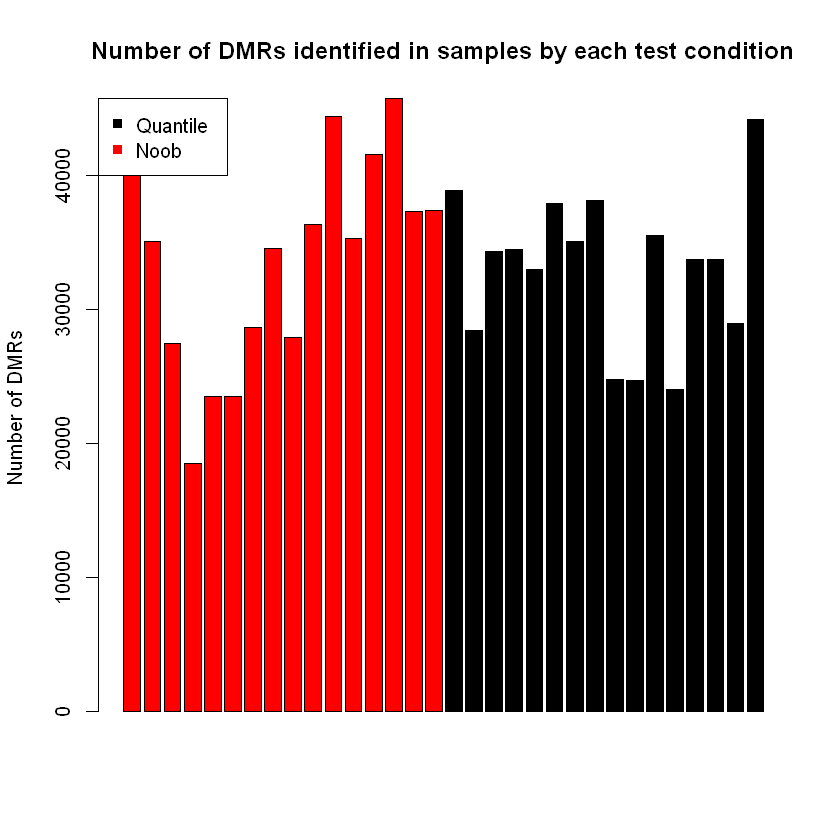

In [29]:
barplot(dmr_results_table$NumberBumps,ylab="Number of DMRs",
        main="Number of DMRs identified in samples by each test condition",col=dmr_results_table$Normalization)
legend("topleft",legend=unique(dmr_results_table$Normalization),col=1:length(dmr_results_table$Normalization),pch=15)

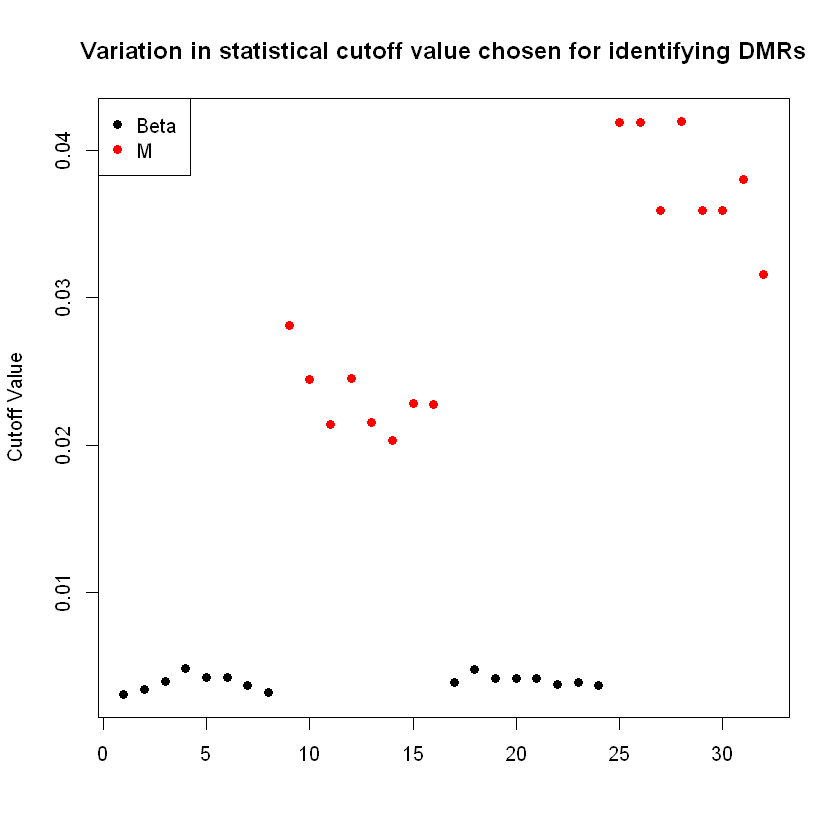

In [30]:
plot(1:length(dmr_results_table[,1]),dmr_results_table$CutoffValue,ylab="Cutoff Value",xlab="",
    main="Variation in statistical cutoff value chosen for identifying DMRs",pch=16,
    col=dmr_results_table$Measure)
legend("topleft",legend=unique(dmr_results_table$Measure),col=1:length(dmr_results_table$Measure),pch=16)

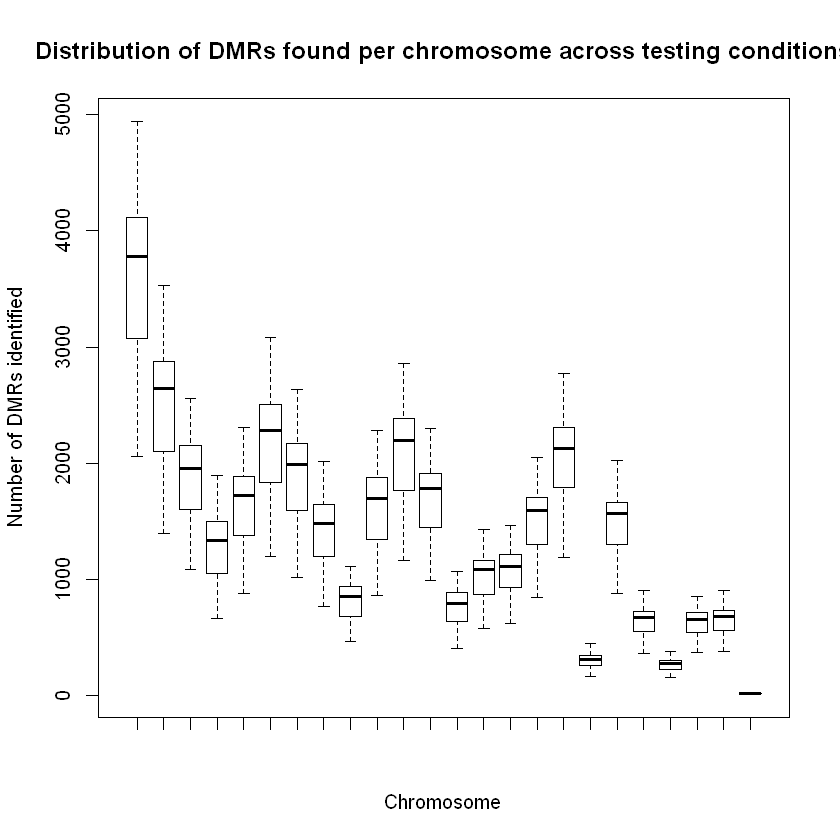

In [34]:
boxplot(dmr_results_table$chr1,dmr_results_table$chr2,dmr_results_table$chr3,dmr_results_table$chr4,dmr_results_table$chr5,
       dmr_results_table$chr6,dmr_results_table$chr7,dmr_results_table$chr8,dmr_results_table$chr9,dmr_results_table$chr10,
       dmr_results_table$chr11,dmr_results_table$chr12,dmr_results_table$chr13,dmr_results_table$chr14,
       dmr_results_table$chr15,dmr_results_table$chr16,dmr_results_table$chr17,dmr_results_table$chr18,
       dmr_results_table$chr19,dmr_results_table$chr20,dmr_results_table$chr21,dmr_results_table$chr22,
       dmr_results_table$chrX,dmr_results_table$chrY,
       main="Distribution of DMRs found per chromosome across testing conditions",xlab="Chromosome",
       ylab="Number of DMRs identified")